In [ ]:
from google.colab import files 
import io
uploaded = files.upload()
files.download('database.xlsx')

Saving database.xlsx to database.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
df  = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/database.xlsx")
df.info()
# Nombre de lignes / colonnes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743821 entries, 0 to 743820
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            743821 non-null  int64  
 1   datasetid             743821 non-null  object 
 2   recordid              743821 non-null  object 
 3   record_timestamp      743821 non-null  object 
 4   fields.iddesserte     743821 non-null  int64  
 5   fields.mnemoligne     741774 non-null  object 
 6   fields.numarret       742913 non-null  float64
 7   fields.etat           743821 non-null  object 
 8   fields.novh           743821 non-null  int64  
 9   fields.nomligne       741774 non-null  object 
 10  fields.harret         743821 non-null  object 
 11  fields.type           743821 non-null  object 
 12  fields.idligne        743821 non-null  int64  
 13  fields.ecart          743821 non-null  int64  
 14  fields.dest           739416 non-null  object 
 15  

On a 743821 lignes.

On a 27 colonnes, on remarque directement qu'on aura des valeurs nulles donc du tri à faire.
On a légèrement plus de colonnes qualitatives que quantitatives.



In [ ]:
df.isna().sum()
# Nombre de NaN values

Unnamed: 0                 0
datasetid                  0
recordid                   0
record_timestamp           0
fields.iddesserte          0
fields.mnemoligne       2047
fields.numarret          908
fields.etat                0
fields.novh                0
fields.nomligne         2047
fields.harret              0
fields.type                0
fields.idligne             0
fields.ecart               0
fields.dest             4405
fields.nomarret          908
fields.mnemoarret        908
fields.coordonnees         0
fields.idarret             0
fields.cap                 0
fields.idparcours       4405
fields.sv                  0
fields.y                   0
fields.x                   0
fields.idvh                0
fields.ts_maj              0
geometry.type              0
geometry.coordinates       0
dtype: int64

On a trouvé que il y a 908 données manquantes pour la colonne "fields.nomarret", "fields.numarret" et la colonne "fields.mnemoarret". C'est à dire qu'ils sont reliés les uns aux autres. Et on a le même cas pour 2047 données manquantes pour la colonne "fields.nomligne", "fields.mnemoligne". Les deux colonnes sont aussi reliés. Et à la fin, on a 4406 données manquante pour la colonne "fields.dest" et la colonne "fields.idparcours".

Vu qu'on travail avec + de 740k données, on va venir supprimer toutes les lignes avec les données manquantes *directement*

In [ ]:
df = df.dropna(axis=0)

# Tri et rename des colonnes

Descriptif de chaque colonne connue

**idvh** Identifiant SAE véhicule

**novh** N° de parc du véhicule

**type** Modèle du véhicule

**etat** Etat SAE du véhicule

**idligne** Identifiant SAE de ligne

**iddesserte** Identifiant SAE de désserte

**x** Coordonnées GPS Lambert 2

**y** Coordonnées GPS Lambert 2

**cap** Cap du véhicule en degrés (gyromètre)

**coordonnees** Coordonnées GPS WG84

**sv** Service voiture

**idarret** Identifiant SAE de l'arrêt

**harret** Heure estimée de passage à L'arrêt

**ecart** Ecart horaire en secondes

**mnemoligne** Mnemo de la ligne

**nomligne** Nom de la ligne

**mnemoarret** Mne de l'arrêt

**nomarret** Nom de l'arrêt

**numarret** N° Timéo de l'arrêt

**idparcours** Identifiant SAE du parcours

**dest** Destination

On va supprimer les colonnes qui ne nous semble pas corrélées à notre variable de prévision. Cependant on garde quand même les colonnes id des colonnes utiles: fields.idligne, id de fields.nomligne par exemple
On supprime 'fields.y', 'fields.x' et 'geometry.coordonnees' car en vérifiant elles ne sont pas correctes et menent a des zones géographiques non cohérentes.

In [114]:

df = df.drop(['Unnamed: 0', 'datasetid', 'record_timestamp','fields.novh', 'fields.iddesserte', 'fields.mnemoarret','fields.sv', 'fields.idvh', 'fields.ts_maj', 'geometry.type', 'fields.y', 'fields.x','geometry.coordinates'], axis=1)

KeyError: ignored

Maintenant on va renommer les colonnes peu parlantes pour qu'elles soient plus compréhensibles et rapides à manipuler.

In [115]:
df = df.rename(columns={'fields.mnemoligne':'numero_ligne','fields.numarret':'numero_arret', 'fields.etat':'vehicule_etat','fields.nomligne':'nom_ligne','fields.harret':'heure_passage_estimee','fields.type':'vehicule_modele','fields.idligne':'id_ligne',
                   'fields.ecart':'ecart_seconde','fields.dest':'destination_ligne','fields.nomarret':'nom_arret','fields.coordonnees':'coordonnees_arret','fields.idarret':'id_arret','fields.cap':'vehicule_cap','fields.idparcours':'id_parcours'})

In [116]:
df['heure_passage_estimee'] = pd.to_datetime(df['heure_passage_estimee'])
df = df.loc[(df['destination_ligne'] != 'TEST NOIR') & (df['destination_ligne'] != 'PAS EN SERVICE')]
df = df.sort_values(by=['numero_ligne','heure_passage_estimee'])

In [117]:
df.reset_index(inplace=True)

ValueError: ignored

On veut savoir les jours par date. En effet les bus ne circulent pas de la même manière en semaine qu'en week end. Il faudra donc /différencier ses jours.

In [ ]:
df['Jour'] = [df['heure_passage_estimee'][i].strftime("%A") for i in range(len(df))]
df['Calendrier'] = [df['heure_passage_estimee'][i].strftime("%m/%d") for i in range(len(df))]  #ajouter une colonne s'appel Calendrier
df['Heure'] = [df['heure_passage_estimee'][i].strftime("%H") for i in range(len(df))]              #ajouter une colonne s'appel Heure

In [ ]:
df = df.drop_duplicates()

Désormais on va ajouter une colonne désignant l'état de la date : vacances scolaires ou période scolaire.
On regarde nos dates min et max afin de voir sur quelle période on fait notre prévision.

In [ ]:
df['heure_passage_estimee'].agg(['min', 'max'])

On notera donc que :      

 

*   Du 2019-08-04 -> 2019-09-01 : Vacances Scolaire (Ete)
*   Du 2019-10-19 -> 2019-11-03 : Vacances Scolaire (Toussaint)

In [ ]:
df.reset_index(inplace=True)

In [ ]:

df['Periode'] = ['Vacances' if (pd.to_datetime('2019-08-04') < df['heure_passage_estimee'][i].date() < pd.to_datetime('2019-09-01')) 
                                or (pd.to_datetime('2019-10-19') < df['heure_passage_estimee'][i].date() < pd.to_datetime('2019-11-03'))
                                else 'Scolaire'
                                for i in range(len(df))]

# STATISTIQUES DESCRIPTIVES

In [119]:

df.info()
df.describe()

KeyboardInterrupt: ignored

Nous avons 691376 lignes et 21 colonnes après le nettoyage des données.

La moyenne de l'ecart du temps de passage sur un arrêt est 177,31 secondes, qui est une valeur positive, c'est à dire, en général, il y a un retard d'environs trois minutes pour le trafic réseau d'irigo. Avec un écart-type de 695,67 secondes.

La moyenne de la capacité du bus est 184,06. Qui ont une valeur presque équivalent à la médiane. Avec un écart-type de 562,07.

# GRAPHIQUES ET ANALYSES

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


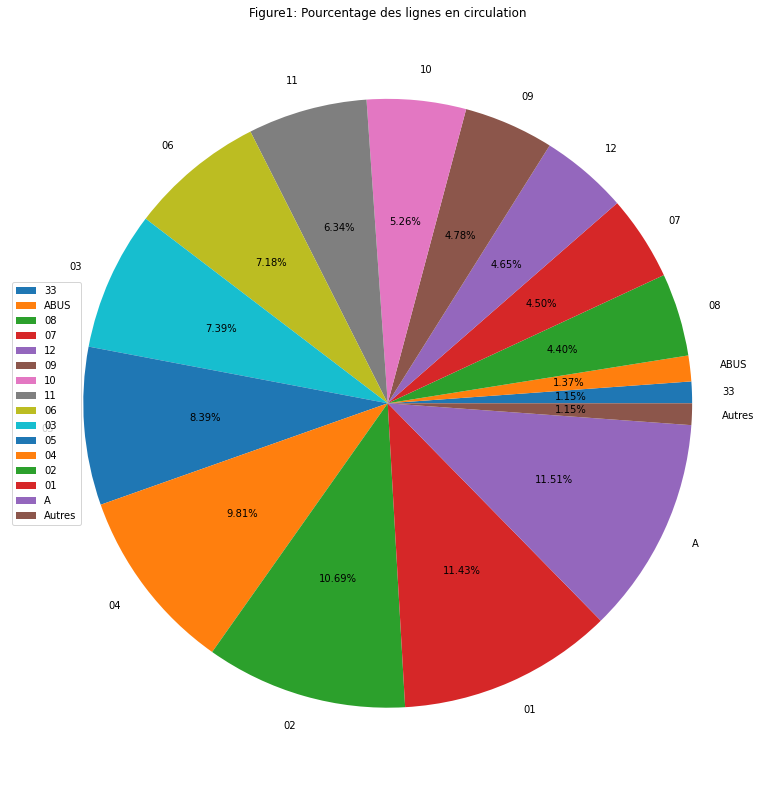

In [ ]:
#1
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
!pip install matplotlib seaborn
from matplotlib import style
y=df["numero_ligne"].value_counts().sort_values().index.tolist()
x=df["numero_ligne"].value_counts().sort_values().values.tolist()
def positionnerPtFiltrage(listValue, somme, typeCalcul):
  rest = 0
  for i in range(len(listValue)):
    rest = rest + listValue[i]
    if(listValue[i] > somme*0.01):
      if (typeCalcul == "point"):
       return i
      else:
       return rest
      
rest = positionnerPtFiltrage(x,sum(x),"rest")
del y[0:positionnerPtFiltrage(x,sum(x),"point")]
del x[0:positionnerPtFiltrage(x,sum(x),"point")]
x.append(positionnerPtFiltrage(x,sum(x),"rest"))
y.append("Autres")
numero_ligne_labels=df['numero_ligne'].value_counts().index
plt.figure(figsize=(40,14))
plt.pie(x, labels=y,autopct='%.2f%%',)
plt.legend(y)
plt.legend(loc='center left')
plt.title('Figure1: Pourcentage des lignes en circulation',loc ='center')
plt.show()

Ce graphique représente la répartition des lignes en service. Il y a plus de 40 lignes sur le réseau. Il y a les lignes de villes (les bus), les lignes de campagnes (les cars) et le tramway (il n’existait que la ligne A à l’époque).
On voit directement les lignes les plus importantes : le tramway A, le 01 et le 02 sont tous les 3 au dessus des 10%. C’est-à-dire que c’est eux qui passent le plus souvent. Par exemple le bus 02 représente 10.69% des passages sur la période donnée.


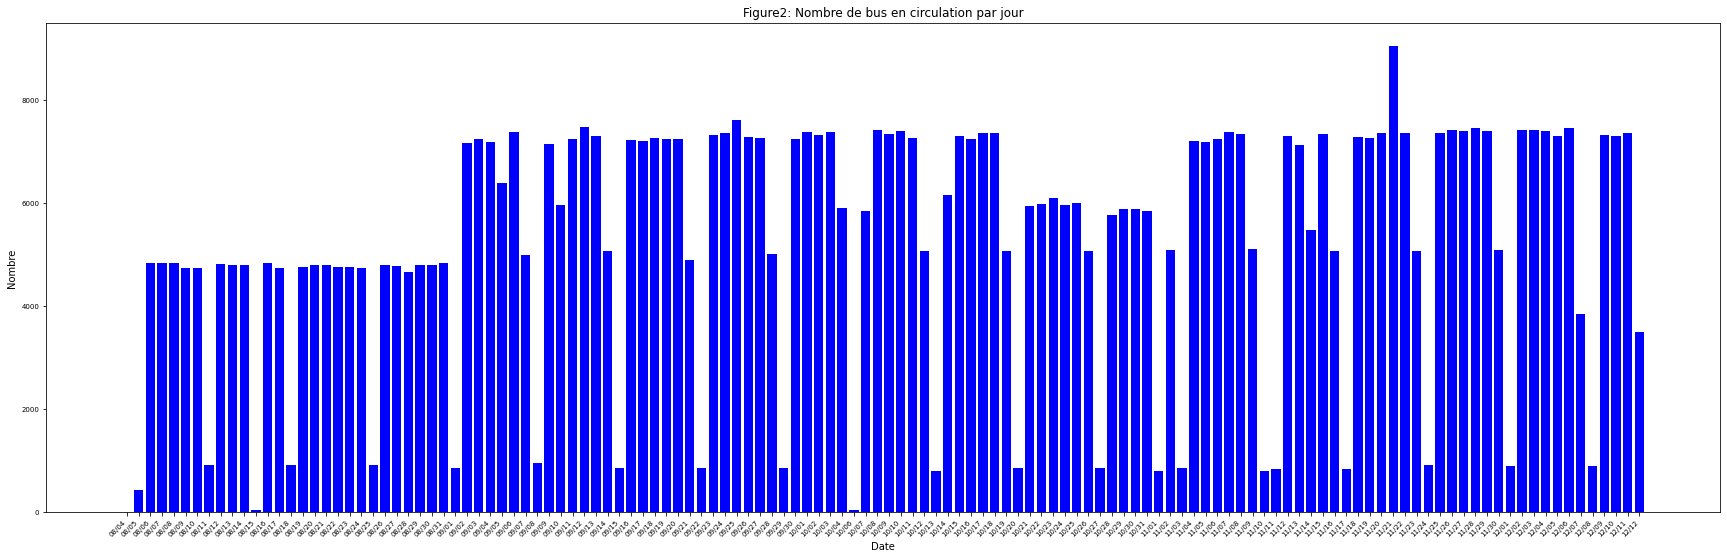

In [ ]:
#2
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

x=df["Calendrier"].value_counts().sort_index().index
y=df["Calendrier"].value_counts().sort_index()

plt.figure(figsize=(30,10))
plt.bar(x, y,color=['blue'])

plt.gcf().autofmt_xdate()
plt.tick_params(labelsize=7)
plt.xticks(rotation=45)     
plt.xlabel('Date')
plt.ylabel('Nombre')
plt.title('Figure2: Nombre de bus en circulation par jour',loc ='center')
plt.show()

Si on regarde les dates on est en période de vacances scolaire (du 4 aout au 1 septembre). Donc il y a moins d’horaires disponibles vu que les personnes prennent moins le bus. Les barres très basses correspondent aux Dimanche, là où les bus circulent très peu. Le 15 août on remarque une chute drastique des bus en circulation, cela s’explique puisque ce jour est férié. On a une tendance à 4900 bus en circulation en moyenne en période de vacances d’été.

On constate un pique au 2 septembre, le jour de la rentrée scolaire.


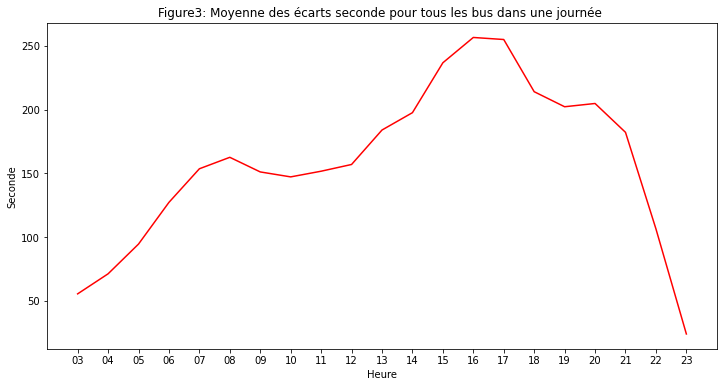

In [ ]:
#3
pd.set_option('display.max_rows', None)

ecart_seconde_heure=df.groupby(['Heure'])['ecart_seconde'].mean()

plt.plot(ecart_seconde_heure.index, ecart_seconde_heure,color="red" )
plt.xlabel('Heure')
plt.ylabel('Seconde')
plt.title('Figure3: Moyenne des écarts seconde pour tous les bus dans une journée ',loc ='center')
plt.show()

On constate un gros pique de retard entre 16h et 18h avec une moyenne de 250 secondes environ. Cela parait logique car ce sont les heures de débauche et donc la circulation est beaucoup plus dense à ces horaires-là.

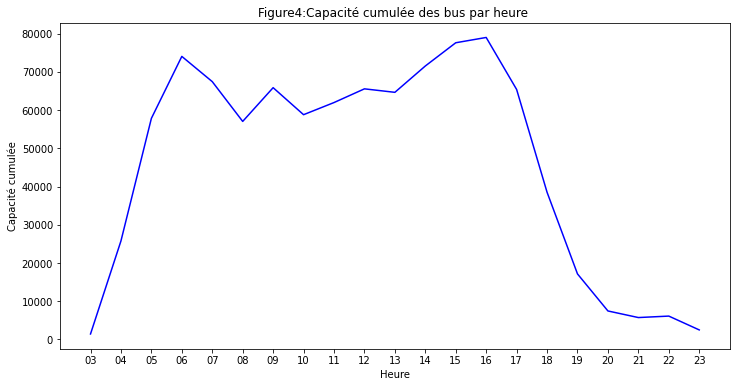

In [ ]:
#4
capacite_heure=df.groupby(['Heure'])['vehicule_cap'].sum()/131 #131 est nombre totale de jours

plt.plot(capacite_heure.index, capacite_heure,c='b' )
plt.xlabel('Heure')
plt.ylabel('Capacité cumulée')
plt.title('Figure4:Capacité cumulée des bus par heure ',loc ='center')
plt.show()

Ce graphique montre l’affluence ou la capacité cumulée des bus cumulée sur une journée.

<Figure size 2160x720 with 0 Axes>

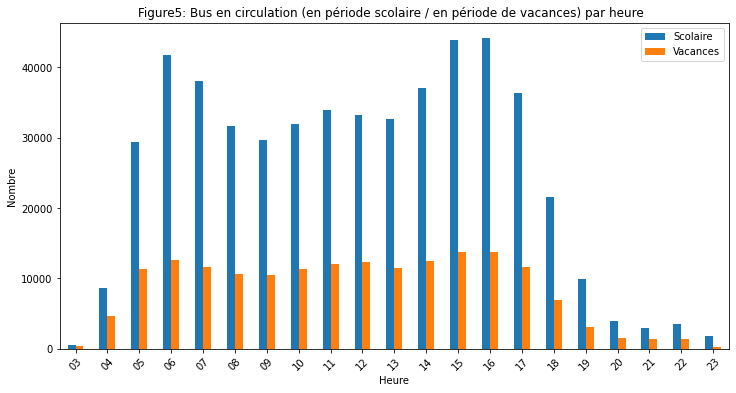

In [ ]:
#5
from matplotlib.pyplot import MultipleLocator
pd.set_option('display.max_rows', None)
#a=df[(df['Periode'] == "Scolaire")].groupby('Heure')["Periode"].value_counts().sort_index()/86
#b=df[(df['Periode'] == "Vacances")].groupby('Heure')["Periode"].value_counts().sort_index()/45
#periode_Heure_moy=pd.merge(periode_scolaire_heure,periode_vacances_heure)
periode_Heure_freq=df.groupby('Heure')["Periode"].value_counts().sort_index()

df_periode_Heure_freq = periode_Heure_freq.unstack()
df_periode_Heure_freq = df_periode_Heure_freq.rename_axis(columns=None)
df_periode_Heure_freq = df_periode_Heure_freq.reset_index(drop=False, inplace=False)
df_periode_Heure_freq = df_periode_Heure_freq.set_index('Heure')
df_periode_Heure_freq=pd.DataFrame(df_periode_Heure_freq, columns=['Scolaire','Vacances'],index=['03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])

plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.figure(figsize=(30,10))
df_periode_Heure_freq.plot(kind='bar', stacked = False)
plt.xticks( range(len(df_periode_Heure_freq.index)) , df_periode_Heure_freq.index)
plt.title('Figure5: Bus en circulation (en période scolaire / en période de vacances) par heure  ',loc ='center')
plt.xticks(rotation=45) 
plt.xlabel('Heure')
plt.ylabel('Nombre')
plt.show()

Ce graphique compare le nombre de transport en commun en circulation en vacances et en période scolaire. On constate que dans la période scolaire il y a des différences flagrantes entre les heures. On a des pics entre 6h-7h et 15h – 17h avec plus de 40 000 bus qui ont circulé. Cependant cette différence se fait moins ressentir en période de vacances. Au maximum on atteint les 12 000 bus en circulation à 16h.

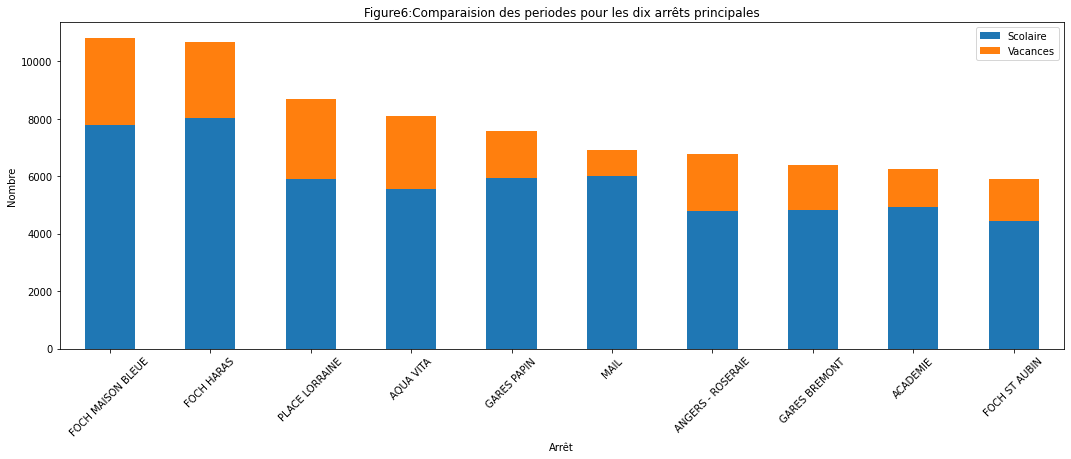

In [ ]:
#6
arret_periode=df.groupby(['nom_arret'])['Periode'].value_counts()
arret_periode=arret_periode.unstack()
arret_periode=pd.DataFrame(arret_periode, 
                         columns=['Scolaire','Vacances'],
                         index=['FOCH MAISON BLEUE','FOCH HARAS','PLACE LORRAINE','AQUA VITA','GARES PAPIN','MAIL','ANGERS - ROSERAIE','GARES BREMONT','ACADEMIE','FOCH ST AUBIN'],
                         )
plt.rcParams['figure.figsize'] = (18.0, 6.0)
arret_periode.plot(kind='bar',stacked = True)
plt.xticks(rotation=45) 
plt.xlabel('Arrêt')
plt.ylabel('Nombre')
plt.title('Figure6:Comparaision des periodes pour les dix arrêts principales',loc ='center')
plt.show()

Ce graphique compare le nombre de bus passant aux principaux arrêts en période scolaire et de vacances. Les arrêts les plus desservis sont ceux du centre ville : foch maison bleue et foch haras, que ce soit en vacances ou non avec environ 8000 passages en période scolaire et 3000 en vacances.

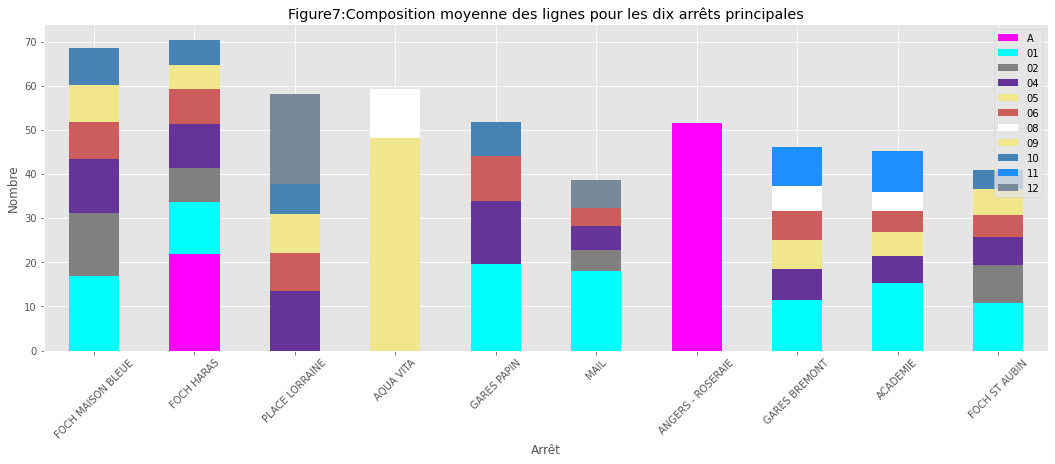

In [112]:
#7
import random
arret_freq=df["nom_arret"].value_counts()
arret_ligne=df.groupby(['numero_ligne'])['nom_arret'].value_counts()/131
arret_ligne=arret_ligne.unstack()
arret_ligne=pd.DataFrame(arret_ligne, 
                         columns=['FOCH MAISON BLEUE','FOCH HARAS','PLACE LORRAINE','AQUA VITA','GARES PAPIN','MAIL','ANGERS - ROSERAIE','GARES BREMONT','ACADEMIE','FOCH ST AUBIN'],
                         index=['A','01','02','03','04','05','06','07','08','09','10','11','12']
                         )
arret_ligne=arret_ligne.dropna(axis=0,how='all')
arret_ligne=arret_ligne.T
all_colors = list(plt.cm.colors.cnames.keys())
c = random.choices(all_colors, k=13)
plt.rcParams['figure.figsize'] = (18.0, 6.0)
arret_ligne.plot(kind='bar',stacked = True,color=c)
plt.xticks(rotation=45)
plt.xlabel('Arrêt')
plt.ylabel('Nombre')
plt.legend(loc='upper right')
plt.title('Figure7:Composition moyenne des lignes pour les dix arrêts principales',loc ='center')
plt.show()

Ce graphique montre la composition moyenne des lignes des bus principaux et le tramway A sur les arrêts principaux. 

<Figure size 2160x720 with 0 Axes>

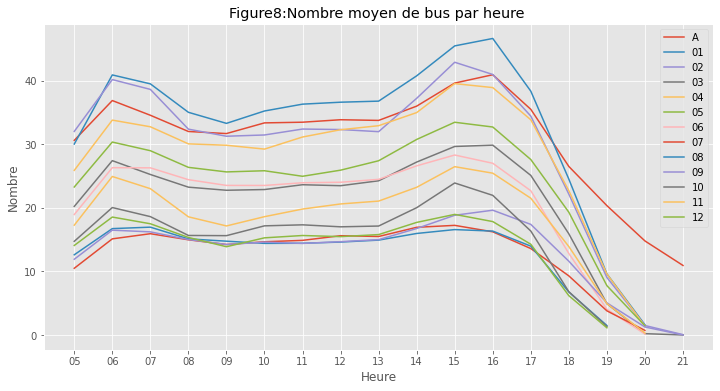

In [113]:
#8
pd.set_option('display.max_rows', None)

ligne_Heure_freq=df.groupby('Heure')["numero_ligne"].value_counts().sort_index()/131

df_ligne_Heure_freq = ligne_Heure_freq.unstack()
df_ligne_Heure_freq = df_ligne_Heure_freq.rename_axis(columns=None)
df_ligne_Heure_freq = df_ligne_Heure_freq.reset_index(drop=False, inplace=False)
df_ligne_Heure_freq = df_ligne_Heure_freq.set_index('Heure')
df_ligne_Heure_freq=pd.DataFrame(df_ligne_Heure_freq, columns=['A','01','02','03','04','05','06','07','08','09','10','11','12'],index=['05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21'])

plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.figure(figsize=(30,10))
df_ligne_Heure_freq.plot()
plt.xticks( range(len(df_ligne_Heure_freq.index)) , df_ligne_Heure_freq.index)
plt.title('Figure8:Nombre moyen de bus par heure ',loc ='center')
plt.xlabel('Heure')
plt.ylabel('Nombre')
plt.show()

Ce graphique nous montre la moyenne du nombre de bus par heure allant des lignes 1 à 12 et le tramway A, en circulation par heure sur la période mi 2019 à fin 2019.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


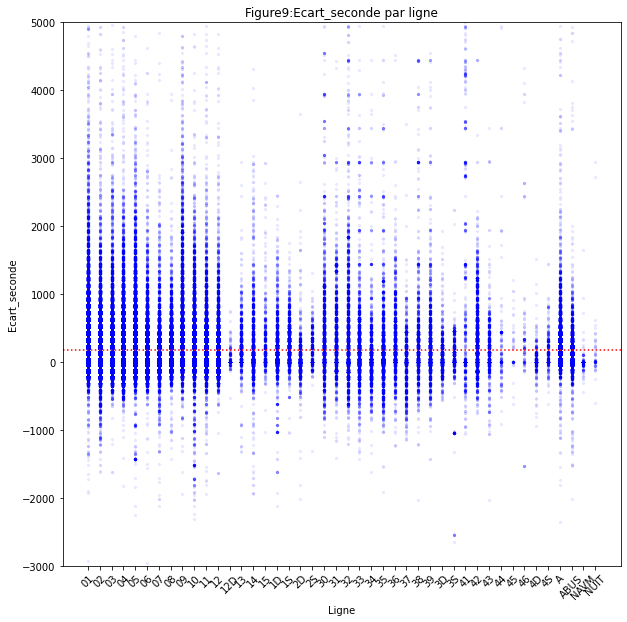

In [ ]:
#9
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
!pip install matplotlib seaborn
from matplotlib import style

plt.figure(figsize=(10,10))
plt.scatter(x=df["numero_ligne"], y=df["ecart_seconde"],color=['blue'], s=5,alpha=1/15)
plt.ylim((-3000, 5000))
plt.axhline(y=df["ecart_seconde"].mean(),ls=":",c="red")# moyen generale de ecart_seconde pour tous bus
plt.tick_params(labelsize=10)
plt.xticks(rotation=45) # Pour que les labels de l'axe des absisses soient plus lisibles
plt.xlabel('Ligne')
plt.ylabel('Ecart_seconde')
plt.title('Figure9:Ecart_seconde par ligne',loc ='center')
plt.show()


Ce graphique permet de facilement voir les retards ou avances des lignes Irigo. On constate que les retards touchent toutes les lignes à plus ou moins grande échelle. 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


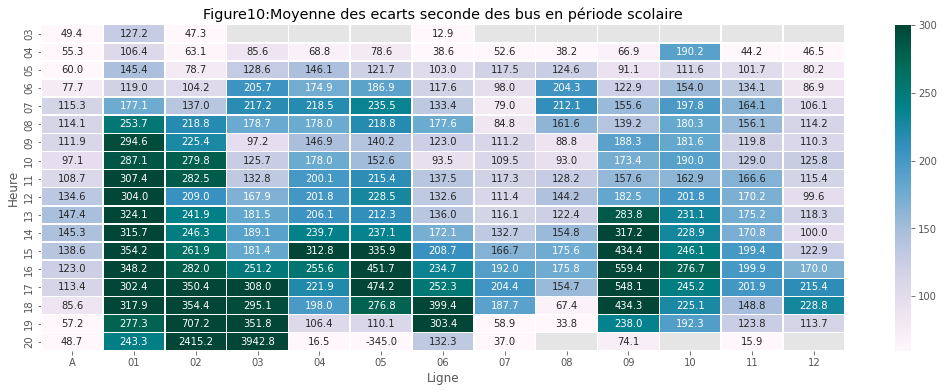

In [87]:
#10
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
!pip install matplotlib seaborn
from matplotlib import style
import numpy as np
plt.style.use('ggplot')
plt.rcParams['axes.unicode_minus']=False

periode_scolaire=df[(df['Periode'] == "Scolaire")]

ligne_heure_ecart_seconde_scolaire=periode_scolaire.groupby(['Heure','numero_ligne'])["ecart_seconde"].mean().sort_index()
ligne_heure_ecart_seconde_scolaire = ligne_heure_ecart_seconde_scolaire.unstack()
ligne_heure_ecart_seconde_scolaire=pd.DataFrame(ligne_heure_ecart_seconde_scolaire, 
                                       columns=['A','01','02','03','04','05','06','07','08','09','10','11','12'],
                                       index=['03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20']
                                       )

sns.heatmap(data = ligne_heure_ecart_seconde_scolaire, 
            vmax=300,
            vmin=60,
            cmap = 'PuBuGn', 
            linewidths = .5, 
            annot = True, 
            fmt='.1f',
            )
plt.xlabel('Ligne')
plt.ylabel('Heure')
plt.title('Figure10:Moyenne des ecarts seconde des bus en période scolaire',loc ='center')
plt.show()

Ce graphique nous montre en moyenne l’écart seconde des bus par heure en période scolaire. 

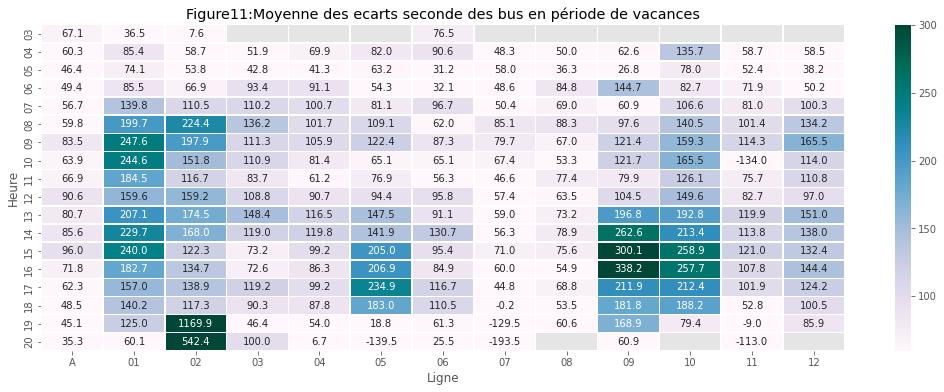

In [88]:
#11
periode_vacances=df[(df['Periode'] == "Vacances")]

ligne_heure_ecart_seconde_vacances=periode_vacances.groupby(['Heure','numero_ligne'])["ecart_seconde"].mean().sort_index()
ligne_heure_ecart_seconde_vacances = ligne_heure_ecart_seconde_vacances.unstack()
ligne_heure_ecart_seconde_vacances=pd.DataFrame(ligne_heure_ecart_seconde_vacances, 
                                       columns=['A','01','02','03','04','05','06','07','08','09','10','11','12'],
                                       index=['03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20']
                                       )

sns.heatmap(data = ligne_heure_ecart_seconde_vacances, 
            vmax=300,
            vmin=60,
            cmap = 'PuBuGn', 
            linewidths = .5, 
            annot = True, 
            fmt='.1f',
            )
plt.xlabel('Ligne')
plt.ylabel('Heure')
plt.title('Figure11:Moyenne des ecarts seconde des bus en période de vacances',loc ='center')
plt.show()

On a tout de suite moins de retard en période de vacances. Même si la ligne 2 est beaucoup impacté le soir. Cela s’explique puisque c’est une des lignes qui circulent le plus en vacances.

# MODELE DE PREVISION DU RETARD

Pour cela on va prédire le retard pour chaque ligne. Notre variable y de prédiction sera donc 'retard'.


In [ ]:
df_pred = df



In [ ]:
df_pred = df_pred.drop(['level_0', 'index'], axis=1)

Regardons la corrélation entre les horaires et les autres variables.

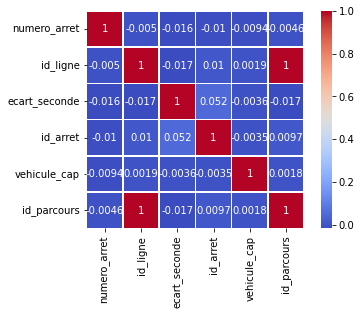

In [ ]:
cor = df_pred.corr() 
sns.heatmap(cor, square = True, cmap="coolwarm",linewidths=.5,annot=True )


On voit qu'il n'y a aucune grosse corrélation entre ecart_seconde et les autres variables.

# ENTRAINEMENT RANDOM FORREST CLASSIFIER

Il faut transformer nos données qualitatives en numériques pour pouvoir faire apprendre nos modèles par la suite.

In [ ]:
df_pred

,recordid,numero_ligne,numero_arret,vehicule_etat,nom_ligne,heure_passage_estimee,vehicule_modele,id_ligne,ecart_seconde,destination_ligne,nom_arret,coordonnees_arret,id_arret,vehicule_cap,id_parcours,Jour,Calendrier,Periode
0,97f6ce6f0689c56277361a552ab05a4d51c5bc50,01,2607.0,TARR,BELLE BEILLE <> MONPLAISIR,2019-08-05 17:44:10+00:00,MAN City,268435457,0,MONPLAISIR,MONPLAISIR,"[47.491016, -0.52782408]",1429594,290,268509440.0,Monday,08/05/2019,Vacances
1,97f6ce6f0689c56277361a552ab05a4d51c5bc50,01,2607.0,TARR,BELLE BEILLE <> MONPLAISIR,2019-08-05 17:44:10+00:00,MAN City,268435457,0,MONPLAISIR,MONPLAISIR,"[47.491016, -0.52782408]",1429594,290,268509440.0,Monday,08/05/2019,Vacances
2,fca68a46e97fe6b917c4be714f2f90824a694bd4,01,26477.0,LIGN,BELLE BEILLE <> MONPLAISIR,2019-08-05 17:44:47+00:00,MAN City,268435457,321,CITE UNIVERSITAIRE,OFFICE DE TOURISME,"[47.46894, -0.55813655]",1428517,58,268545536.0,Monday,08/05/2019,Vacances
3,d256116331bdd077cabb56b796160ec1f9b3e536,01,30745.0,LIGN,BELLE BEILLE <> MONPLAISIR,2019-08-05 17:44:50+00:00,MAN City,268435457,51,MONPLAISIR,JERUSALEM,"[47.473505, -0.52981607]",1428311,23,268509440.0,Monday,08/05/2019,Vacances
4,6e16bdd53966c9d74ae0a6d501d431e4ff2b46dd,01,20081.0,LIGN,BELLE BEILLE <> MONPLAISIR,2019-08-05 17:45:36+00:00,GX 427 Hyb,268435457,-23,MONPLAISIR,SAINTE CROIX,"[47.470866, -0.5534623]",1428675,117,268509440.0,Monday,08/05/2019,Vacances
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691371,6f5b7c2626ab8d00785f9b5b0750ae9b211b3048,NUIT,3820.0,LIGN,SERVICE NUIT,2019-11-29 04:45:13+00:00,CITYSTD,268435483,433,IRIGO NUIT,AURIOL,"[47.492299, -0.56562185]",1646401,95,270250496.0,Friday,11/29/2019,Scolaire
691372,6bc00b133c0eed3ca8506f4da939cd3aa85f0040,NUIT,29694.0,LIGN,SERVICE NUIT,2019-11-30 04:44:20+00:00,CITYSTD,268435483,213,IRIGO NUIT,MONPROFIT,"[47.474243, -0.56706729]",1648911,259,270250496.0,Saturday,11/30/2019,Scolaire
691373,6bc00b133c0eed3ca8506f4da939cd3aa85f0040,NUIT,17939.0,LIGN,SERVICE NUIT,2019-11-30 04:59:55+00:00,CITYSTD,268435483,2,IRIGO NUIT,SAINT JACQUES,"[47.473582, -0.57153167]",1649114,98,270250496.0,Saturday,11/30/2019,Scolaire
691374,6bc00b133c0eed3ca8506f4da939cd3aa85f0040,NUIT,20531.0,LIGN,SERVICE NUIT,2019-11-30 05:14:50+00:00,CITYSTD,268435483,-128,IRIGO NUIT,JOXE,"[47.483995, -0.54165376]",1649689,196,270250496.0,Saturday,11/30/2019,Scolaire


In [ ]:
df_pred['Retard'] = [1 if df_pred['ecart_seconde'][i] > 60
                        else 0
                        for i in range(len(df_pred))]

In [ ]:

n=1
dict_vehicule_etat = {}

for element in df['vehicule_etat'].unique():

  dict_vehicule_etat[element] = n
  n+=1

j=1
dict_nom_ligne = {}

for element in df['nom_ligne'].unique():

  dict_nom_ligne[element] = j
  j+=1

r=1
dict_numero_ligne = {}

for element in df['numero_ligne'].unique():

  dict_numero_ligne[element] = r
  r+=1

k=1
dict_vehicule_modele = {}

for element in df['vehicule_modele'].unique():

  dict_vehicule_modele[element] = k
  k+=1

l=1
dict_dest_ligne = {}

for element in df['destination_ligne'].unique():

  dict_dest_ligne[element] = l
  l+=1

m=1
dict_nom_arret = {}

for element in df['nom_arret'].unique():

  dict_nom_arret[element] = m
  m+=1

w=1
dict_jour = {}

for element in df['Jour'].unique():

  dict_jour[element] = w
  w+=1

u=1
dict_periode = {}

for element in df['Periode'].unique():

  dict_periode[element] = u
  u+=1

In [ ]:
df_pred = df_pred.replace({'vehicule_etat':dict_vehicule_etat, 'nom_ligne':dict_nom_ligne, 'numero_ligne':dict_numero_ligne, 'vehicule_modele':dict_vehicule_modele, 'destination_ligne':dict_dest_ligne, 'nom_arret': dict_nom_arret, 'Jour': dict_jour, 'Periode':dict_periode})

In [ ]:
df_pred['heure_passage_estimee'] = pd.to_numeric(pd.to_datetime(df_pred['heure_passage_estimee']))

In [ ]:
df_pred = df_pred.drop(['recordid','coordonnees_arret','Calendrier'], axis=1)

In [ ]:

columns = df_pred.columns.tolist()
# Filtrer les colonnes pour supprimer celles que nous ne voulons pas.
X = df_pred[[c for c in columns if c not in ["Retard","ecart_seconde"]]]
Y = df_pred["Retard"]

In [96]:
from sklearn.model_selection import train_test_split
X_train,X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=5)

#CLASSIFICATION MODEL

In [103]:

from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=100, max_features='log2')

clf.fit(X_train,Y_train)

y_pred=clf.predict(X_test)

In [105]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print(f"Accuracy:{round(metrics.accuracy_score(Y_test, y_pred),2)}")
print(f"Precision:{round(metrics.precision_score(Y_test, y_pred),2)}")
print(f"Recall:{round(metrics.recall_score(Y_test, y_pred),2)}")

Accuracy:0.77
Precision:0.74
Recall:0.76


# PLUS PROCHE VOISIN

In [109]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, Y_train)
y_pred = neigh.predict(X_test)


print(f"Accuracy:{round(metrics.accuracy_score(Y_test, y_pred),2)}")
print(f"Precision:{round(metrics.precision_score(Y_test, y_pred),2)}")
print(f"Recall:{round(metrics.recall_score(Y_test, y_pred),2)}")

Accuracy:0.59
Precision:0.56
Recall:0.49


SVM CLASSIFICATION

In [110]:
from sklearn import svm

SVM = svm.LinearSVC()
SVM.fit(X_train, Y_train)
SVM.predict(X_test)

print(f"Accuracy:{round(metrics.accuracy_score(Y_test, y_pred),2)}")
print(f"Precision:{round(metrics.precision_score(Y_test, y_pred),2)}")
print(f"Recall:{round(metrics.recall_score(Y_test, y_pred),2)}")


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy:0.59
Precision:0.56
Recall:0.49


In [111]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr')
LR.fit(X_train, Y_train)
LR.predict(X_test)

print(f"Accuracy:{round(metrics.accuracy_score(Y_test, y_pred),2)}")
print(f"Precision:{round(metrics.precision_score(Y_test, y_pred),2)}")
print(f"Recall:{round(metrics.recall_score(Y_test, y_pred),2)}")

Accuracy:0.59
Precision:0.56
Recall:0.49
